In [106]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot stying
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model 
from keras.layers import LSTM

# sklearn functionalities
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image, IFrame

# Artificial Neural Networks for Time Series Forecasting

<strong>Artificial neural networks (ANNs)</strong> are computing systems inspired by the biological neural networks that constitute bilological brains. Such systems learn (progressively improve performance) to do tasks by considering examples, generally without task-specific programming (if-then clauses).

An ANN is based on a collection of connected units called <strong>Perceptrons</strong> analogous to neurons in a biological brain. Each connection (synapse) between neurons can transmit a signal to another neuron. The receiving (postsynaptic) neuron can process the signal(s) and then signal downstream neurons connected to it. - <a href="https://en.wikipedia.org/wiki/Artificial_neural_network">Wikipedia</a>

https://www.youtube.com/watch?v=MVyauNNinC0


## Neural Network Basics

The basic constitutes of a ANN are **Perceptron**. A perceptron takes an input matrix $X$ and applies weights $W$ to each resulting in a weighted sum. This summed is transformed using an **Activation Function** and passed as the output $y$, also called **activation**. An activation function is a decision making function that determines the presence / importance of particular neural feature. It is (typically) mapped between 0 and 1, where zero mean the feature is not there, while one means the feature is present.

In [107]:
IFrame("./img/perceptron.pdf", width=1000, height=800)

The purpose of the activation function is to introduce non-linearity into the network. Non-linear means that the output cannot be reproduced from a linear combination of the inputs. Since the perceptron is a **linear classifier**, i.e. it can only distinguish between two forms of output (e.g. 0 and 1), it is not capable of solving XOR problems like this

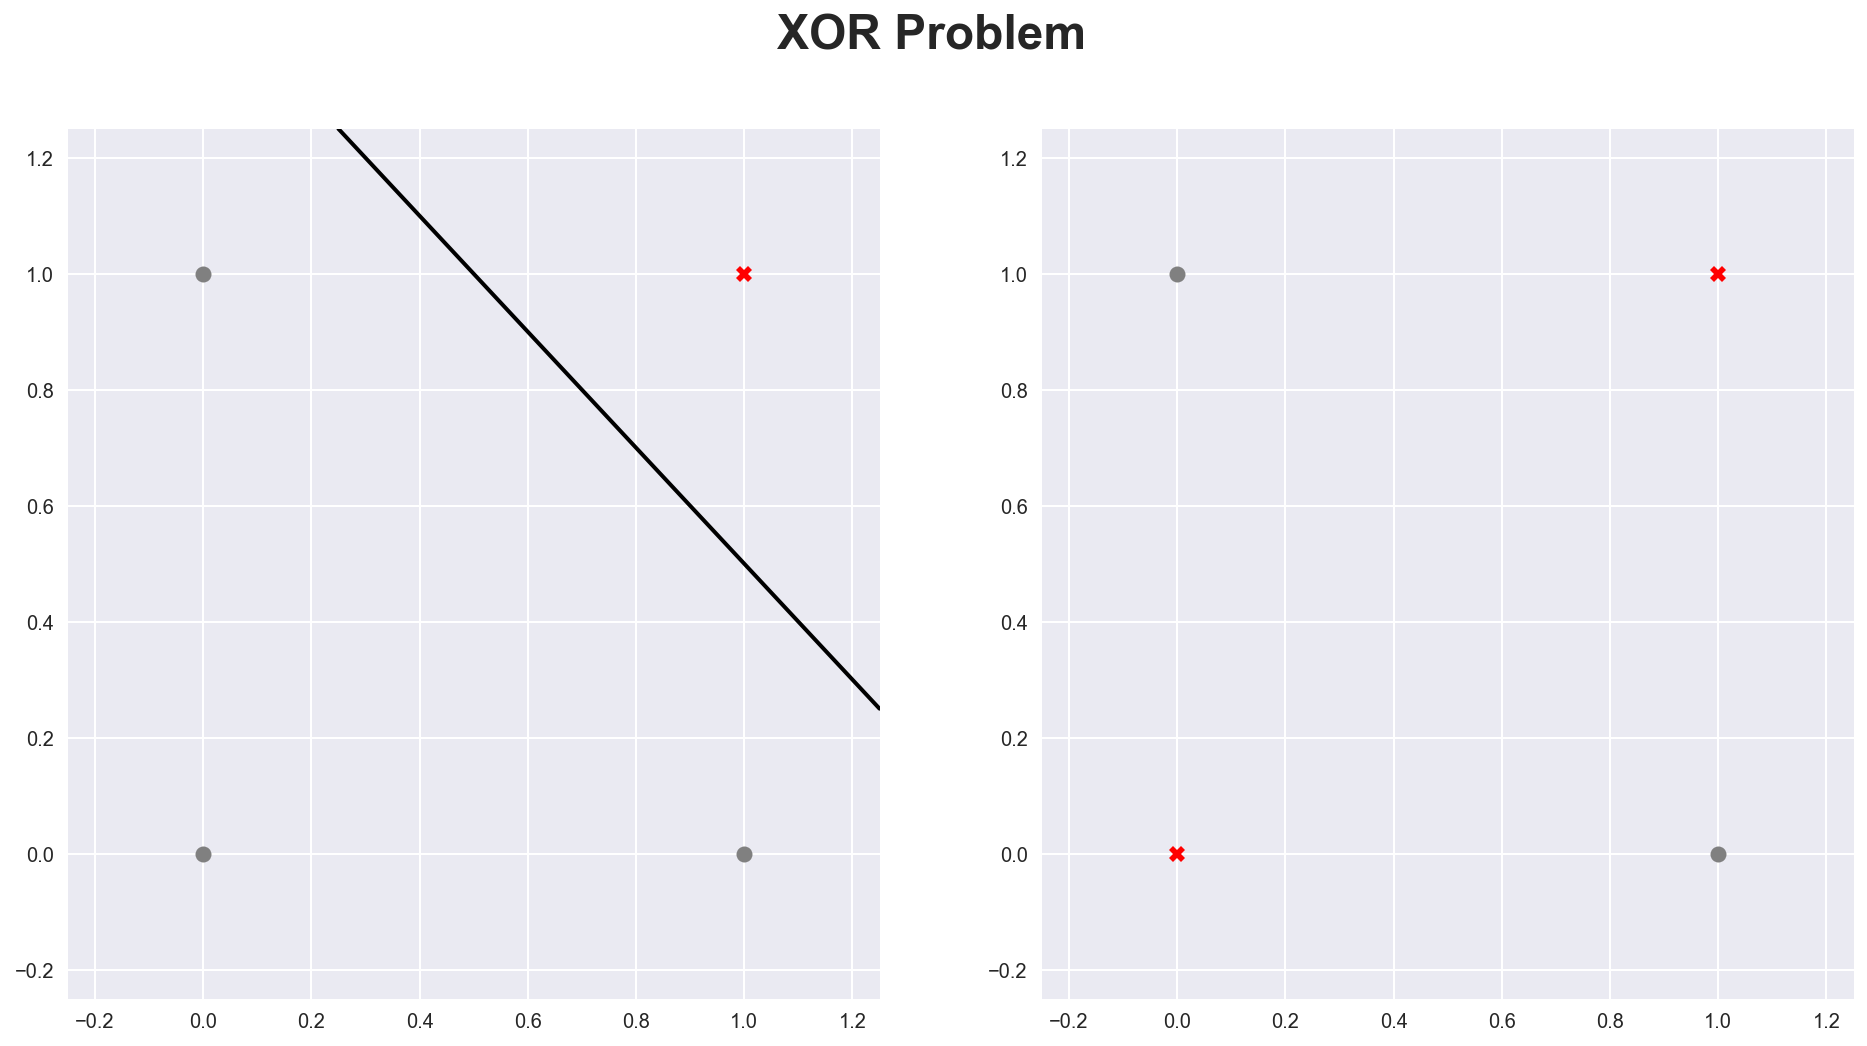

In [110]:
# initialize figur and axes
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False);
fig.suptitle('XOR Problem', fontsize=24, fontweight='bold')

# classifiable plot
axes[0].plot([0,0,1], [0,1,0], 'o', color='grey')
axes[0].plot([1], [1], 'X', color='red')
axes[0].plot([0.25, 1.25], [1.25, 0.25], color='black')
axes[0].set_xlim((-0.25, 1.25))
axes[0].set_ylim((-0.25, 1.25))

# unclassifiable plot
axes[1].plot([0,1], [1,0], 'o', color='grey')
axes[1].plot([0, 1], [0, 1], 'X', color='red')
axes[1].set_xlim((-0.25, 1.25))
axes[1].set_ylim((-0.25, 1.25))

plt.show()

The limitations of the perceptron to estimate non-linear relationships is solved by chaining together multiple perceptrons to form a network, an artificial neural network. The same input pass through principle as for a single perceptron applies for all network nodes which will eventually result in the output estimate $\hat{y}$.

In [112]:
IFrame("./img/network.pdf", width=1000, height=800)

The estimate $\hat{y}$ is then compared to the actual observation $y$ using a <strong>Cost Function</strong> $E$ which computes the sum of squared errors. 

In [113]:
IFrame("./img/error_computation.pdf", width=1000, height=800)

If the cost function is minimized with respect to all weight parameters in $W$ the neural network learns the most effective (cheapest) representation of the data that leads to the desired result $y$. According to each weight's contribution to the total error $\delta E / \delta w_{ij}$ this error is propagated back through the network to the corresponding which which are than adjusted by a **learning rate**. This process is called **Back Propagation** since the errors are propagated back through the network. The optimal parameter constellati0on is than found by the **Gradient Descent Algorithm**

1. initialize with weights w_{ij}^{(0)}
2. for s = 1 to S do:
3.     compute $E[w_{ij}^{(s-1)}]$
4.     compute $w_{ij}^{(s)} = w_{ij}^{(s-1)} - \eta \frac{\partial E}{\partial w_{ij}^{(s)}}$   

until $E$ is sufficient small

In [100]:
IFrame("./img/gradient_descent.pdf", width=1000, height=800)

## A Supervised Learning Task

Time series prediction problems are inherently different from supervised learning problems in that obervastions posses a timely ordering and no observeable input. Thus, the time series prediction problem has to be converted into a regression problem.

A supervised learing problem requires data of the form $(X, y)$ where $y$ is the observeable output and $X$ is a matrix of input data which is assumed to cause the observed output. Since the output variable $y$ is continuous this problem is called a supervised regression problem.

In [170]:
np.random.seed(7)

In [171]:
df = pd.read_csv('./data/passengers.csv', sep=';', parse_dates=True, index_col=0)
data = df.values

# using keras often requires the data type float32
data = data.astype('float32')

# slice the data
train = data[0:120, :]
test = data[120:, :]

print(len(train), len(test))

120 24


In [172]:
data

array([[ 112.],
       [ 118.],
       [ 132.],
       [ 129.],
       [ 121.],
       [ 135.],
       [ 148.],
       [ 148.],
       [ 136.],
       [ 119.],
       [ 104.],
       [ 118.],
       [ 115.],
       [ 126.],
       [ 141.],
       [ 135.],
       [ 125.],
       [ 149.],
       [ 170.],
       [ 170.],
       [ 158.],
       [ 133.],
       [ 114.],
       [ 140.],
       [ 145.],
       [ 150.],
       [ 178.],
       [ 163.],
       [ 172.],
       [ 178.],
       [ 199.],
       [ 199.],
       [ 184.],
       [ 162.],
       [ 146.],
       [ 166.],
       [ 171.],
       [ 180.],
       [ 193.],
       [ 181.],
       [ 183.],
       [ 218.],
       [ 230.],
       [ 242.],
       [ 209.],
       [ 191.],
       [ 172.],
       [ 194.],
       [ 196.],
       [ 196.],
       [ 236.],
       [ 235.],
       [ 229.],
       [ 243.],
       [ 264.],
       [ 272.],
       [ 237.],
       [ 211.],
       [ 180.],
       [ 201.],
       [ 204.],
       [ 188.],
       [

The <code>prepare_data</code> function will be used to transform the time series into a regression problem. The <code>lags</code> argument takes an integer which corresponds the the number of previous time steps to use as input variables to predict the next time period. The default value is one but will be changed in a next iteration.

With the default setting a data set will be created where $X$ is the number of passengers at time $t$ and $y$ is the number of passengers at time $t+1$.

In [173]:
len(train)

120

In [174]:
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

In [175]:
lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test     # due to naming convention

In [176]:
y_train

array([ 118.,  132.,  129.,  121.,  135.,  148.,  148.,  136.,  119.,
        104.,  118.,  115.,  126.,  141.,  135.,  125.,  149.,  170.,
        170.,  158.,  133.,  114.,  140.,  145.,  150.,  178.,  163.,
        172.,  178.,  199.,  199.,  184.,  162.,  146.,  166.,  171.,
        180.,  193.,  181.,  183.,  218.,  230.,  242.,  209.,  191.,
        172.,  194.,  196.,  196.,  236.,  235.,  229.,  243.,  264.,
        272.,  237.,  211.,  180.,  201.,  204.,  188.,  235.,  227.,
        234.,  264.,  302.,  293.,  259.,  229.,  203.,  229.,  242.,
        233.,  267.,  269.,  270.,  315.,  364.,  347.,  312.,  274.,
        237.,  278.,  284.,  277.,  317.,  313.,  318.,  374.,  413.,
        405.,  355.,  306.,  271.,  306.,  315.,  301.,  356.,  348.,
        355.,  422.,  465.,  467.,  404.,  347.,  305.,  336.,  340.,
        318.,  362.,  348.,  363.,  435.,  491.,  505.,  404.,  359.,  310.], dtype=float32)

In [177]:
X_train

array([[ 112.],
       [ 118.],
       [ 132.],
       [ 129.],
       [ 121.],
       [ 135.],
       [ 148.],
       [ 148.],
       [ 136.],
       [ 119.],
       [ 104.],
       [ 118.],
       [ 115.],
       [ 126.],
       [ 141.],
       [ 135.],
       [ 125.],
       [ 149.],
       [ 170.],
       [ 170.],
       [ 158.],
       [ 133.],
       [ 114.],
       [ 140.],
       [ 145.],
       [ 150.],
       [ 178.],
       [ 163.],
       [ 172.],
       [ 178.],
       [ 199.],
       [ 199.],
       [ 184.],
       [ 162.],
       [ 146.],
       [ 166.],
       [ 171.],
       [ 180.],
       [ 193.],
       [ 181.],
       [ 183.],
       [ 218.],
       [ 230.],
       [ 242.],
       [ 209.],
       [ 191.],
       [ 172.],
       [ 194.],
       [ 196.],
       [ 196.],
       [ 236.],
       [ 235.],
       [ 229.],
       [ 243.],
       [ 264.],
       [ 272.],
       [ 237.],
       [ 211.],
       [ 180.],
       [ 201.],
       [ 204.],
       [ 188.],
       [

In [178]:
y_train

array([ 118.,  132.,  129.,  121.,  135.,  148.,  148.,  136.,  119.,
        104.,  118.,  115.,  126.,  141.,  135.,  125.,  149.,  170.,
        170.,  158.,  133.,  114.,  140.,  145.,  150.,  178.,  163.,
        172.,  178.,  199.,  199.,  184.,  162.,  146.,  166.,  171.,
        180.,  193.,  181.,  183.,  218.,  230.,  242.,  209.,  191.,
        172.,  194.,  196.,  196.,  236.,  235.,  229.,  243.,  264.,
        272.,  237.,  211.,  180.,  201.,  204.,  188.,  235.,  227.,
        234.,  264.,  302.,  293.,  259.,  229.,  203.,  229.,  242.,
        233.,  267.,  269.,  270.,  315.,  364.,  347.,  312.,  274.,
        237.,  278.,  284.,  277.,  317.,  313.,  318.,  374.,  413.,
        405.,  355.,  306.,  271.,  306.,  315.,  301.,  356.,  348.,
        355.,  422.,  465.,  467.,  404.,  347.,  305.,  336.,  340.,
        318.,  362.,  348.,  363.,  435.,  491.,  505.,  404.,  359.,  310.], dtype=float32)

The data set now has the following form
<pre>
X       y
112     118
118     132
132     129
129     121
121     135
</pre>
That is, the function has successfully shifted the data for one time step and saved this new shifted series to an array.

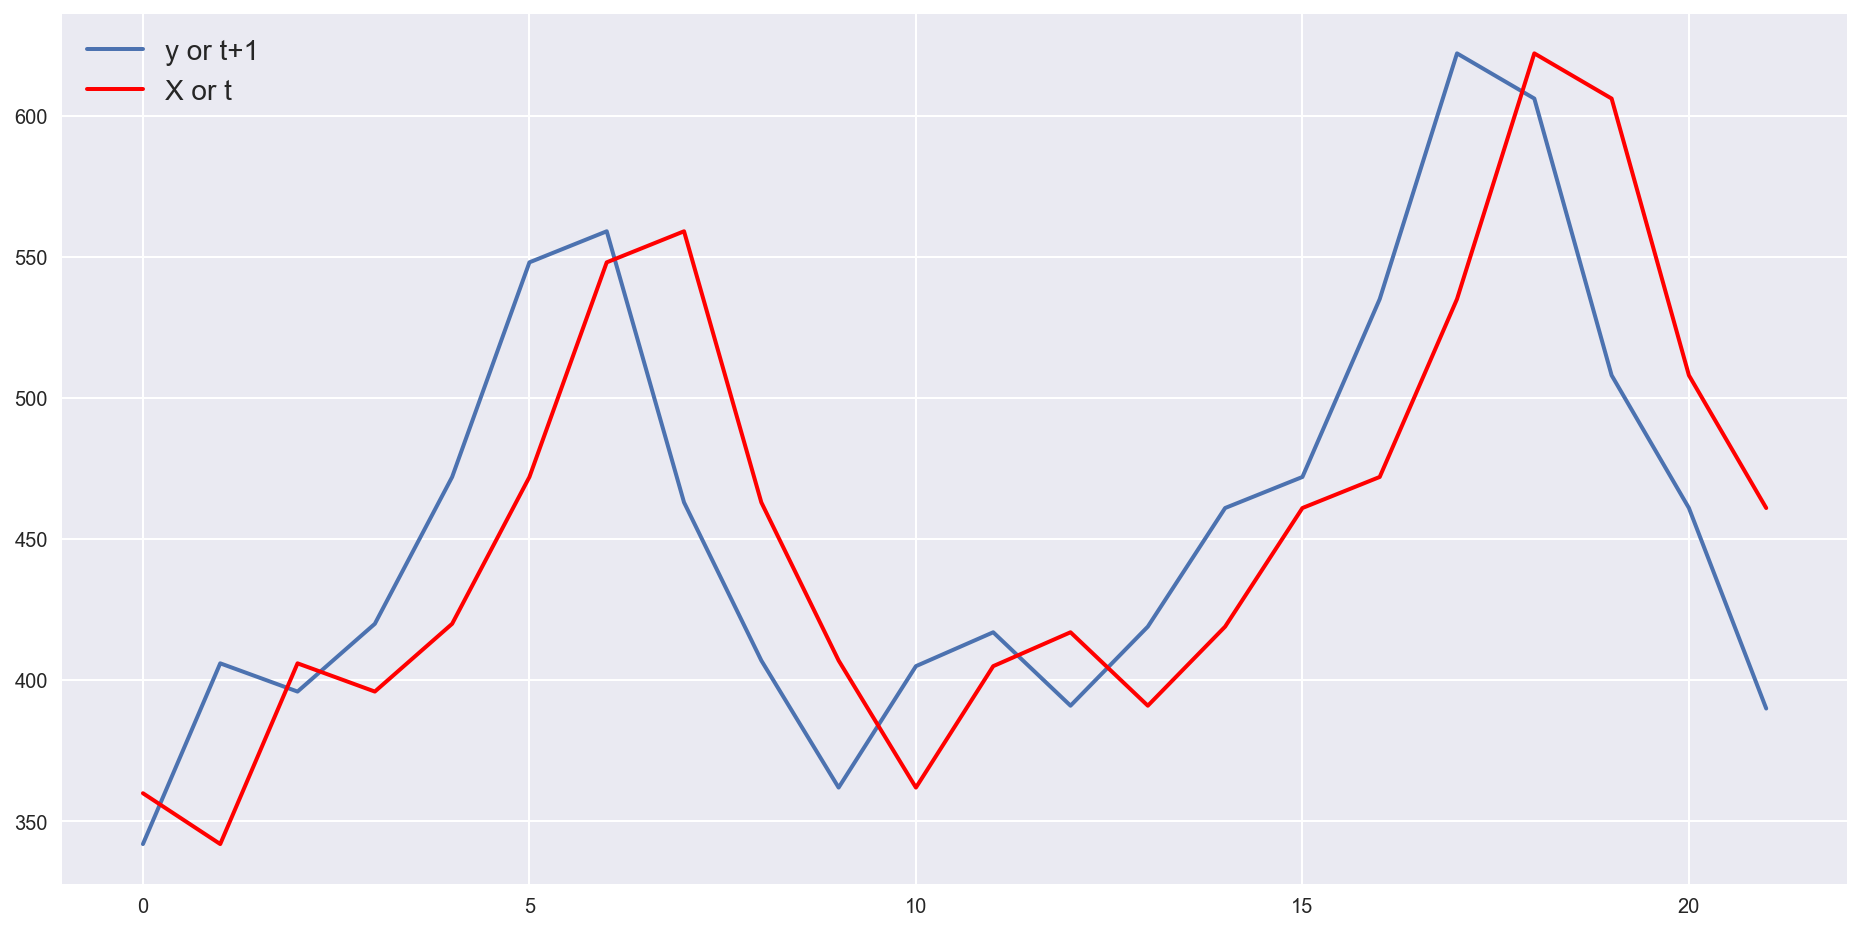

In [179]:
# plot the created data
plt.plot(y_test, label='y or t+1')
plt.plot(X_test, label='X or t', color='red')
plt.legend(loc='upper left')
plt.show()

## Multilayer Perceptron Network

As previously, the data is sliced up into a <code>train</code> and <code>test</code> set to evaluate the performance of a two-year-ahead forecast.

The first simple network will have one input (size of the <code>lags</code> variable), one hidden layer with 8 neurons and an output layer. The model is fitted using the MSE criterion and rectified linear units as activation function

In [180]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(8, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
0s - loss: 64459.3960
Epoch 2/200
0s - loss: 54669.2084
Epoch 3/200
0s - loss: 44603.8422
Epoch 4/200
0s - loss: 34450.7245
Epoch 5/200
0s - loss: 24874.6734
Epoch 6/200
0s - loss: 16626.4277
Epoch 7/200
0s - loss: 10198.5824
Epoch 8/200
0s - loss: 5843.2282
Epoch 9/200
0s - loss: 3188.6783
Epoch 10/200
0s - loss: 1822.7421
Epoch 11/200
0s - loss: 1202.0025
Epoch 12/200
0s - loss: 949.4789
Epoch 13/200
0s - loss: 861.5221
Epoch 14/200
0s - loss: 840.2471
Epoch 15/200
0s - loss: 829.5842
Epoch 16/200
0s - loss: 829.4176
Epoch 17/200
0s - loss: 829.8608
Epoch 18/200
0s - loss: 825.5628
Epoch 19/200
0s - loss: 826.1765
Epoch 20/200
0s - loss: 827.8869
Epoch 21/200
0s - loss: 831.7827
Epoch 22/200
0s - loss: 827.2399
Epoch 23/200
0s - loss: 826.7122
Epoch 24/200
0s - loss: 824.1505
Epoch 25/200
0s - loss: 825.6398
Epoch 26/200
0s - loss: 831.9010
Epoch 27/200
0s - loss: 824.5786
Epoch 28/200
0s - loss: 827.5407
Epoch 29/200
0s - loss: 830.5044
Epoch 30/200
0s - loss: 830.7231
E

In [181]:
# estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 816.12 MSE (28.57 RMSE)
Test Score: 2799.35 MSE (52.91 RMSE)


In [182]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

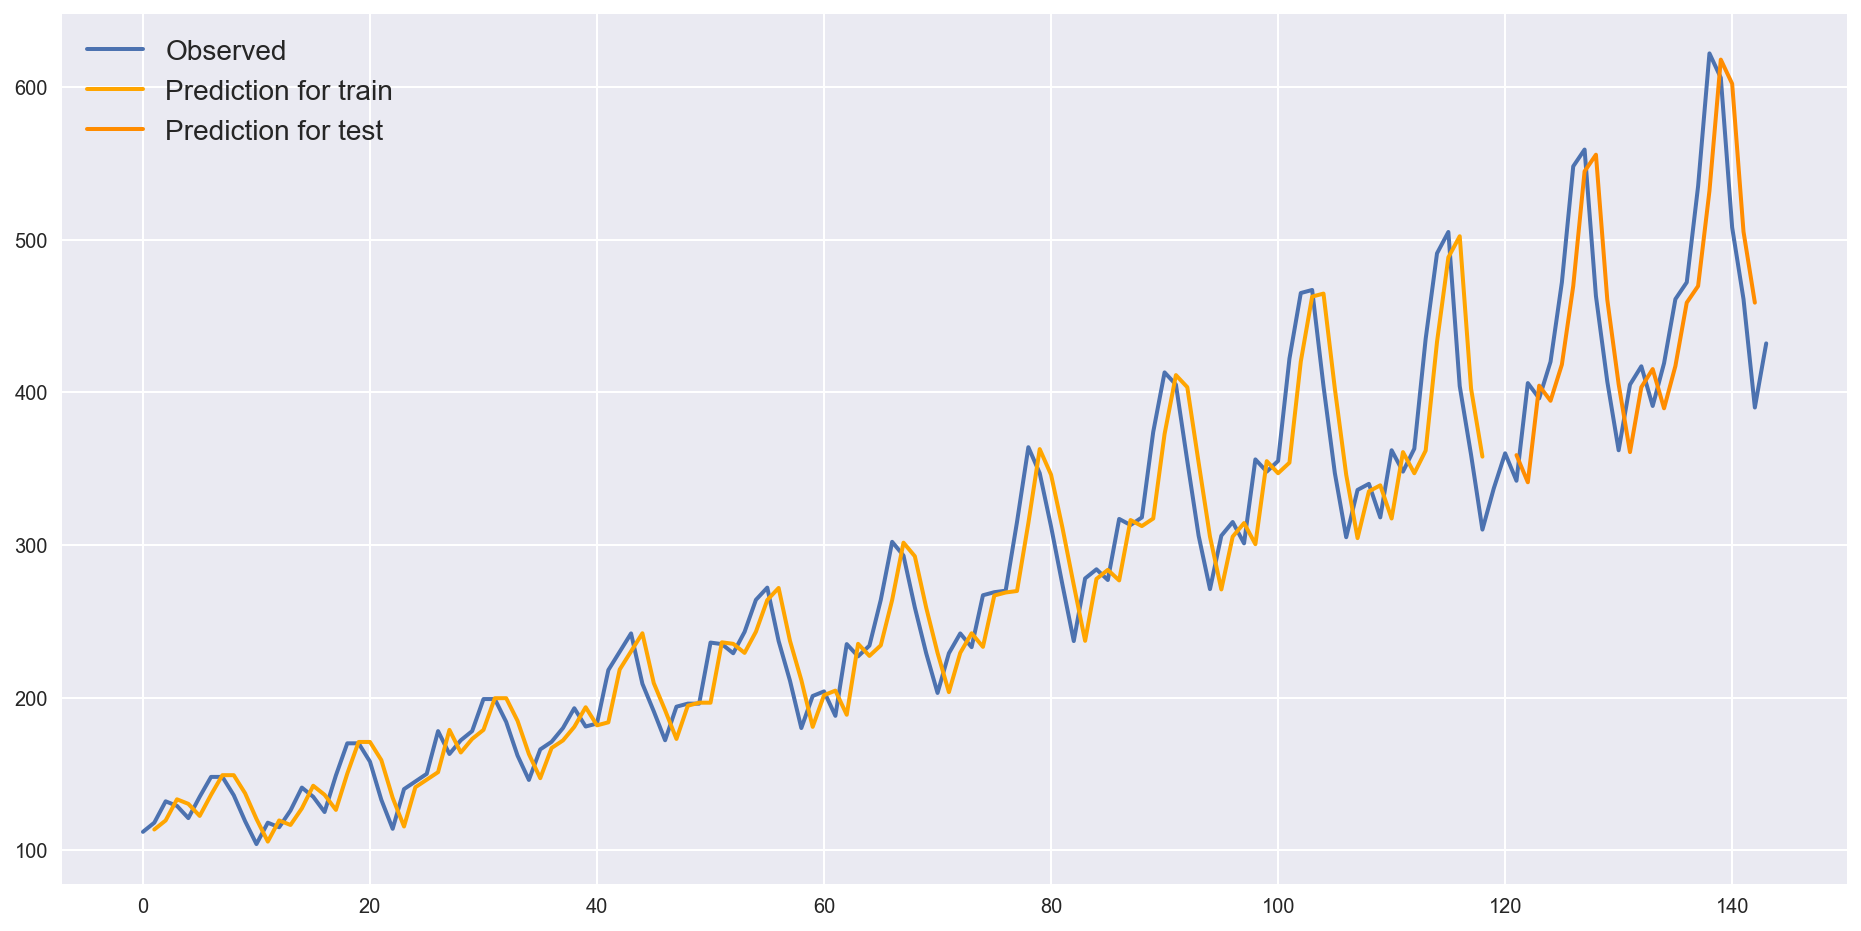

In [183]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(data)-1, :] = test_predict

# plot baseline and predictions
plt.plot(data, label='Observed');
plt.plot(train_predict_plot, label='Prediction for train', color='orange');
plt.plot(test_predict_plot, label='Prediction for test', color='darkorange');
plt.legend(loc='best');
plt.show()

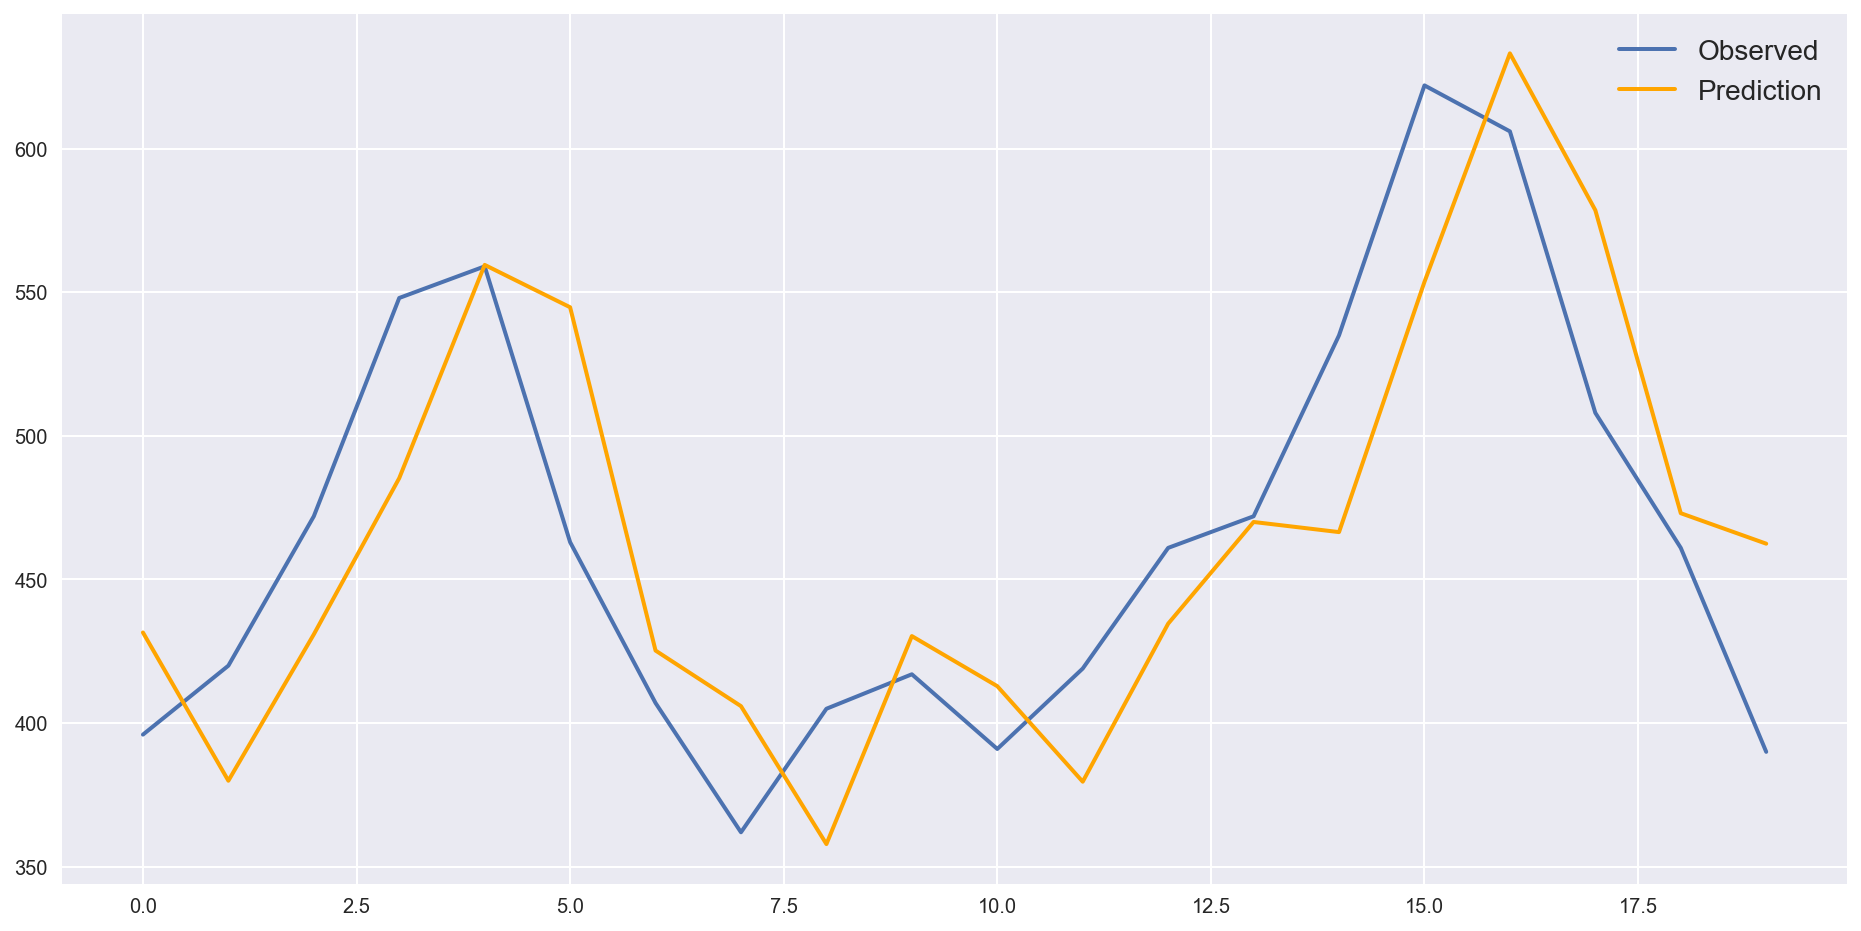

In [202]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='orange')
plt.legend(loc='best');
plt.show()

Since the neural network has only been fed by the last observation, it did not have much choice but to learn to apply observation $t$ for the prediction of $t+1$.

## Multilayer perceptron with window

In [192]:
# reshape dataset
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

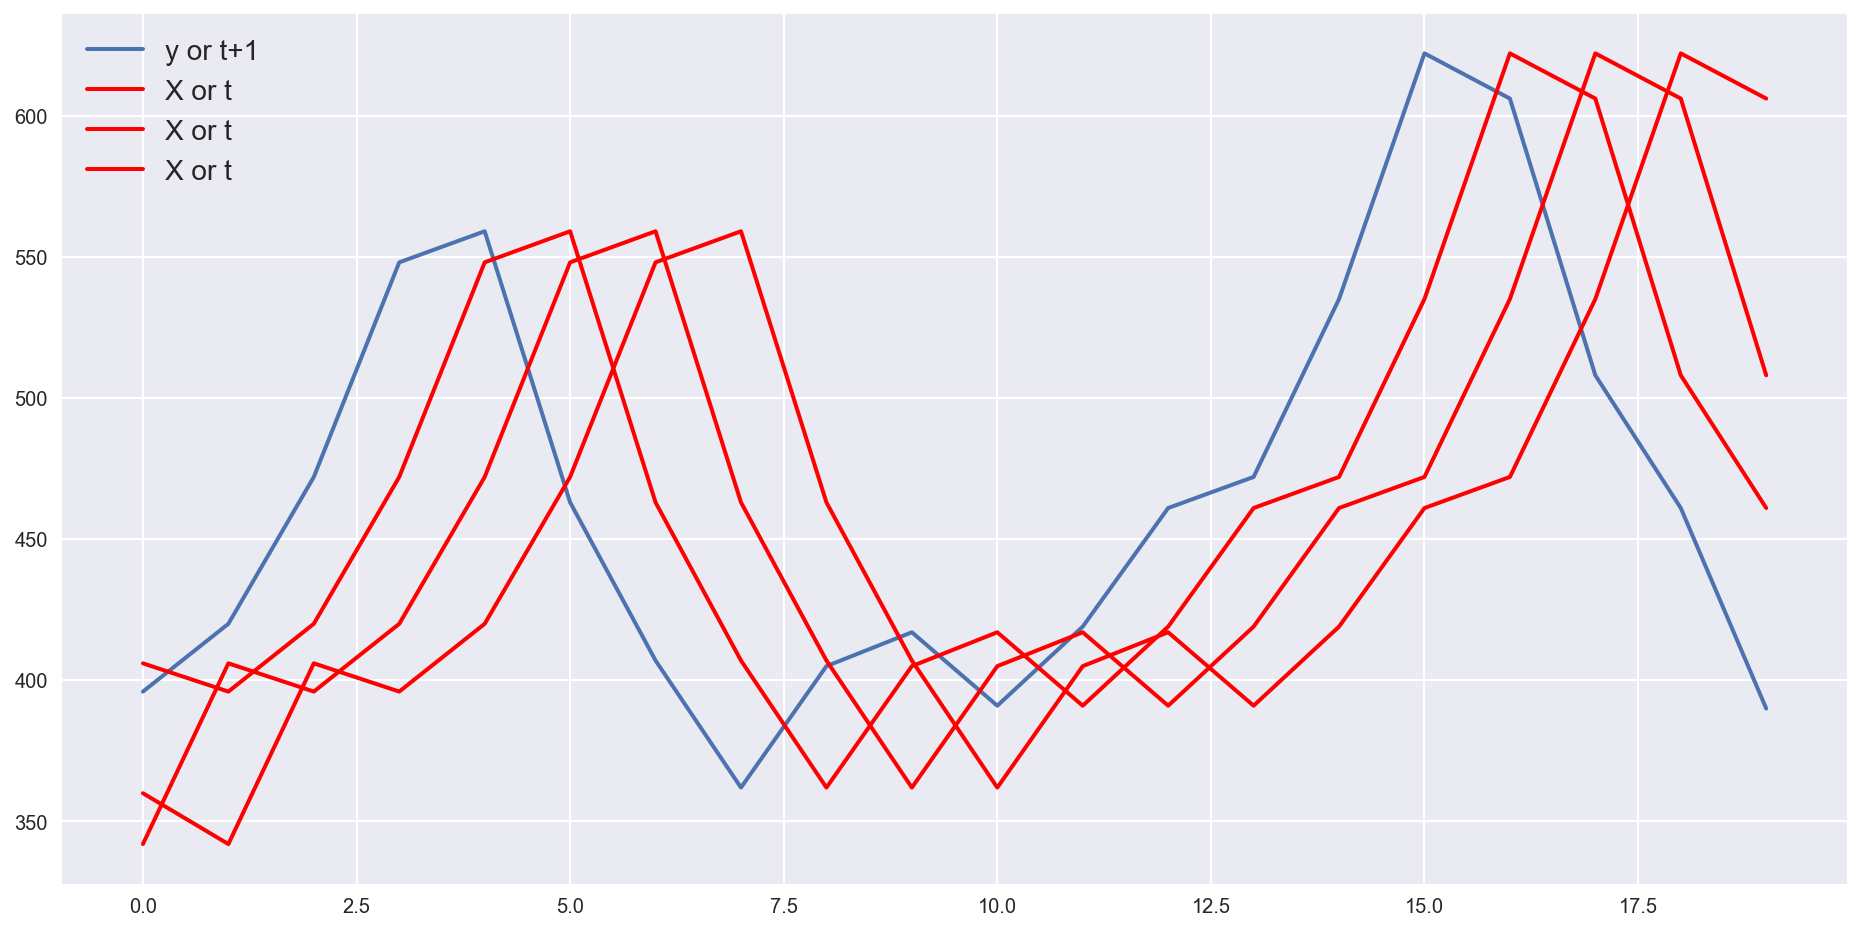

In [193]:
# plot the created data
plt.plot(y_test, label='y or t+1')
plt.plot(X_test, label='X or t', color='red')
plt.legend(loc='best')
plt.show()

In [194]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(12, input_dim=lags, activation='relu'))
mdl.add(Dense(8, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=400, batch_size=2, verbose=2)

Epoch 1/400
0s - loss: 3649.1689
Epoch 2/400
0s - loss: 1847.3930
Epoch 3/400
0s - loss: 1723.0033
Epoch 4/400
0s - loss: 1600.5609
Epoch 5/400
0s - loss: 1520.6919
Epoch 6/400
0s - loss: 1324.6329
Epoch 7/400
0s - loss: 1266.3049
Epoch 8/400
0s - loss: 1246.1917
Epoch 9/400
0s - loss: 1124.6148
Epoch 10/400
0s - loss: 1160.4942
Epoch 11/400
0s - loss: 1077.1692
Epoch 12/400
0s - loss: 1065.7547
Epoch 13/400
0s - loss: 983.1079
Epoch 14/400
0s - loss: 936.2968
Epoch 15/400
0s - loss: 904.0998
Epoch 16/400
0s - loss: 873.2924
Epoch 17/400
0s - loss: 869.4143
Epoch 18/400
0s - loss: 938.9953
Epoch 19/400
0s - loss: 894.7325
Epoch 20/400
0s - loss: 827.1134
Epoch 21/400
0s - loss: 772.1465
Epoch 22/400
0s - loss: 855.4918
Epoch 23/400
0s - loss: 813.1962
Epoch 24/400
0s - loss: 810.7514
Epoch 25/400
0s - loss: 781.3295
Epoch 26/400
0s - loss: 770.8407
Epoch 27/400
0s - loss: 809.5174
Epoch 28/400
0s - loss: 756.4061
Epoch 29/400
0s - loss: 797.9565
Epoch 30/400
0s - loss: 770.3061
Epoch 3

0s - loss: 820.3327
Epoch 249/400
0s - loss: 782.8401
Epoch 250/400
0s - loss: 729.7344
Epoch 251/400
0s - loss: 769.5636
Epoch 252/400
0s - loss: 753.2021
Epoch 253/400
0s - loss: 767.0108
Epoch 254/400
0s - loss: 707.9591
Epoch 255/400
0s - loss: 859.5782
Epoch 256/400
0s - loss: 760.4266
Epoch 257/400
0s - loss: 750.2679
Epoch 258/400
0s - loss: 741.0809
Epoch 259/400
0s - loss: 767.5783
Epoch 260/400
0s - loss: 772.4424
Epoch 261/400
0s - loss: 762.8678
Epoch 262/400
0s - loss: 731.1774
Epoch 263/400
0s - loss: 801.1432
Epoch 264/400
0s - loss: 738.5137
Epoch 265/400
0s - loss: 800.9510
Epoch 266/400
0s - loss: 723.7885
Epoch 267/400
0s - loss: 762.9716
Epoch 268/400
0s - loss: 743.2270
Epoch 269/400
0s - loss: 735.5189
Epoch 270/400
0s - loss: 751.0936
Epoch 271/400
0s - loss: 767.3810
Epoch 272/400
0s - loss: 733.0765
Epoch 273/400
0s - loss: 769.1478
Epoch 274/400
0s - loss: 777.3946
Epoch 275/400
0s - loss: 786.7475
Epoch 276/400
0s - loss: 787.7014
Epoch 277/400
0s - loss: 754

In [195]:
# Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 712.45 MSE (26.69 RMSE)
Test Score: 2152.18 MSE (46.39 RMSE)


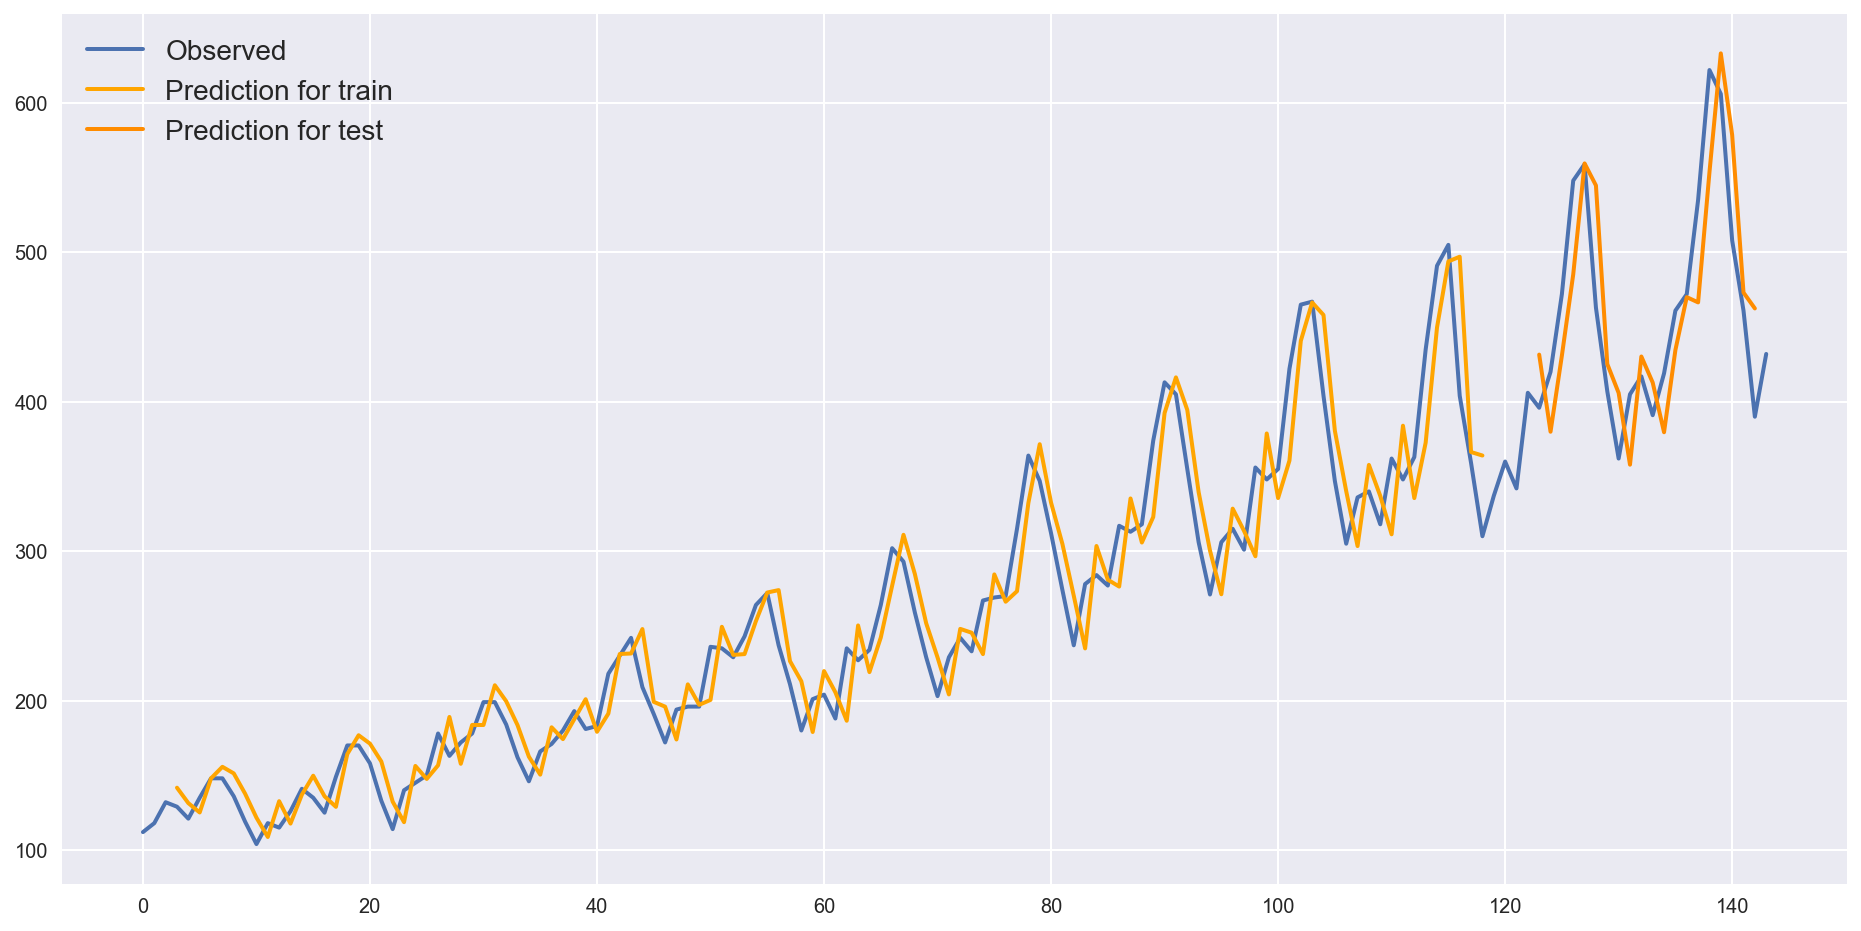

In [196]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags * 2)+1:len(data)-1, :] = test_predict

# plot observation and predictions
plt.plot(data, label='Observed');
plt.plot(train_predict_plot, label='Prediction for train', color='orange');
plt.plot(test_predict_plot, label='Prediction for test', color='darkorange');
plt.legend(loc='best');
plt.show()

In [197]:
y_test

array([ 396.,  420.,  472.,  548.,  559.,  463.,  407.,  362.,  405.,
        417.,  391.,  419.,  461.,  472.,  535.,  622.,  606.,  508.,
        461.,  390.], dtype=float32)

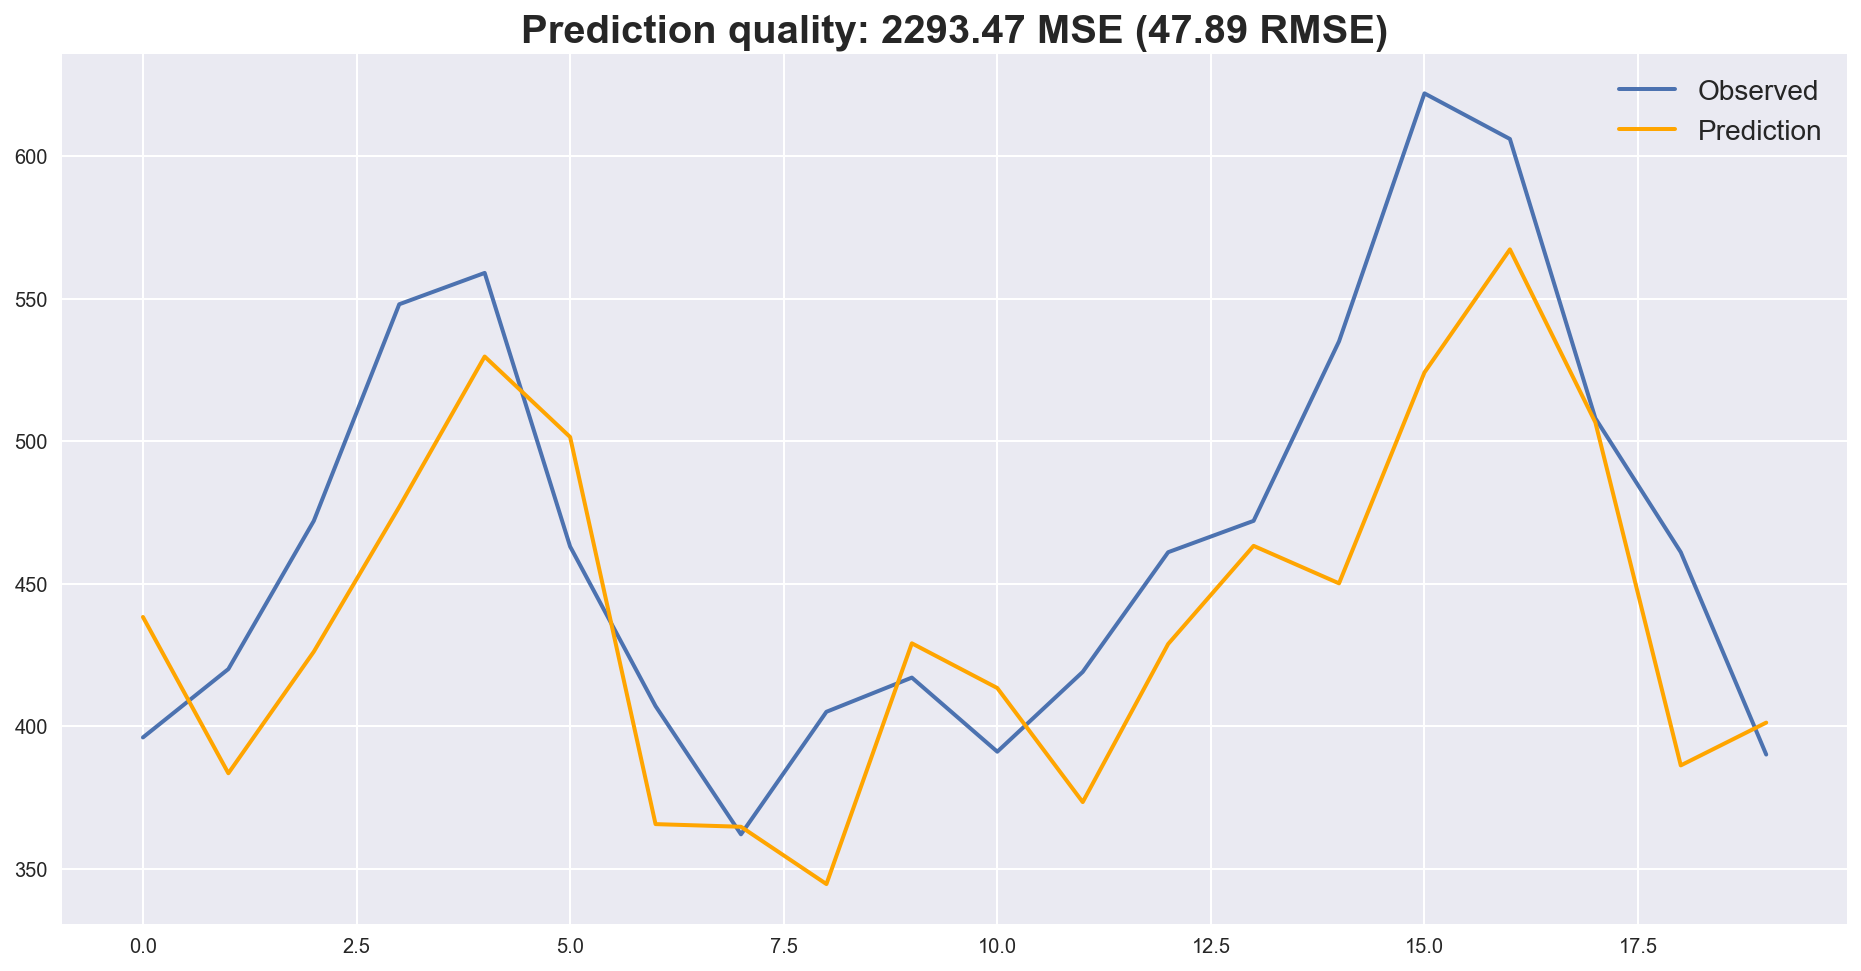

In [229]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='orange')
plt.legend(loc='best');
plt.show()

# LSTM Recurrent Neural Network

Long short-term memory (LSTM) is a recurrent neural network (RNN) architecture that remembers values over arbitrary intervals. Stored values are not modified as learning proceeds. RNNs allow forward and backward connections between neurons. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. - <a href="https://en.wikipedia.org/wiki/Long_short-term_memory">Wikipedia</a>

## Architecture



LSTM blocks contain three or four "gates" that control information flow. These gates are implemented using the logistic function to compute a value between 0 and 1. Multiplication is applied with this value to partially allow or deny information to flow into or out of the memory. For example, an "input" gate controls the extent to which a new value flows into the memory. A "forget" gate controls the extent to which a value remains in memory. An "output" gate controls the extent to which the value in memory is used to compute the output activation of the block. (In some implementations, the input and forget gates are merged into a single gate. The motivation for combining them is that the time to forget is when a new value worth remembering becomes available.)

In [220]:
# fix random seed for reproducibility
np.random.seed(1)

# load the dataset
df = pd.read_csv('./data/passengers.csv', sep=';', parse_dates=True, index_col=0)
data = df.values
data = data.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# split into train and test sets
train = dataset[0:120, :]
test = dataset[120:, :]

# reshape into X=t and Y=t+1
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [221]:
# create and fit the LSTM network
model = Sequential()
model.add(Dense(3, input_shape=(1, lags), activation='relu'))
model.add(LSTM(4))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0811
Epoch 2/100
0s - loss: 0.0271
Epoch 3/100
0s - loss: 0.0206
Epoch 4/100
0s - loss: 0.0174
Epoch 5/100
0s - loss: 0.0148
Epoch 6/100
0s - loss: 0.0126
Epoch 7/100
0s - loss: 0.0107
Epoch 8/100
0s - loss: 0.0091
Epoch 9/100
0s - loss: 0.0080
Epoch 10/100
0s - loss: 0.0071
Epoch 11/100
0s - loss: 0.0070
Epoch 12/100
0s - loss: 0.0060
Epoch 13/100
0s - loss: 0.0057
Epoch 14/100
0s - loss: 0.0052
Epoch 15/100
0s - loss: 0.0048
Epoch 16/100
0s - loss: 0.0047
Epoch 17/100
0s - loss: 0.0040
Epoch 18/100
0s - loss: 0.0042
Epoch 19/100
0s - loss: 0.0038
Epoch 20/100
0s - loss: 0.0035
Epoch 21/100
0s - loss: 0.0032
Epoch 22/100
0s - loss: 0.0032
Epoch 23/100
0s - loss: 0.0029
Epoch 24/100
0s - loss: 0.0028
Epoch 25/100
0s - loss: 0.0029
Epoch 26/100
0s - loss: 0.0029
Epoch 27/100
0s - loss: 0.0027
Epoch 28/100
0s - loss: 0.0027
Epoch 29/100
0s - loss: 0.0027
Epoch 30/100
0s - loss: 0.0026
Epoch 31/100
0s - loss: 0.0026
Epoch 32/100
0s - loss: 0.0025
Epoch 33/100
0s -

In [222]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [223]:
# invert transformation
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [224]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: {:.2f} RMSE'.format(test_score))

Train Score: 25.61 RMSE
Test Score: 47.89 RMSE


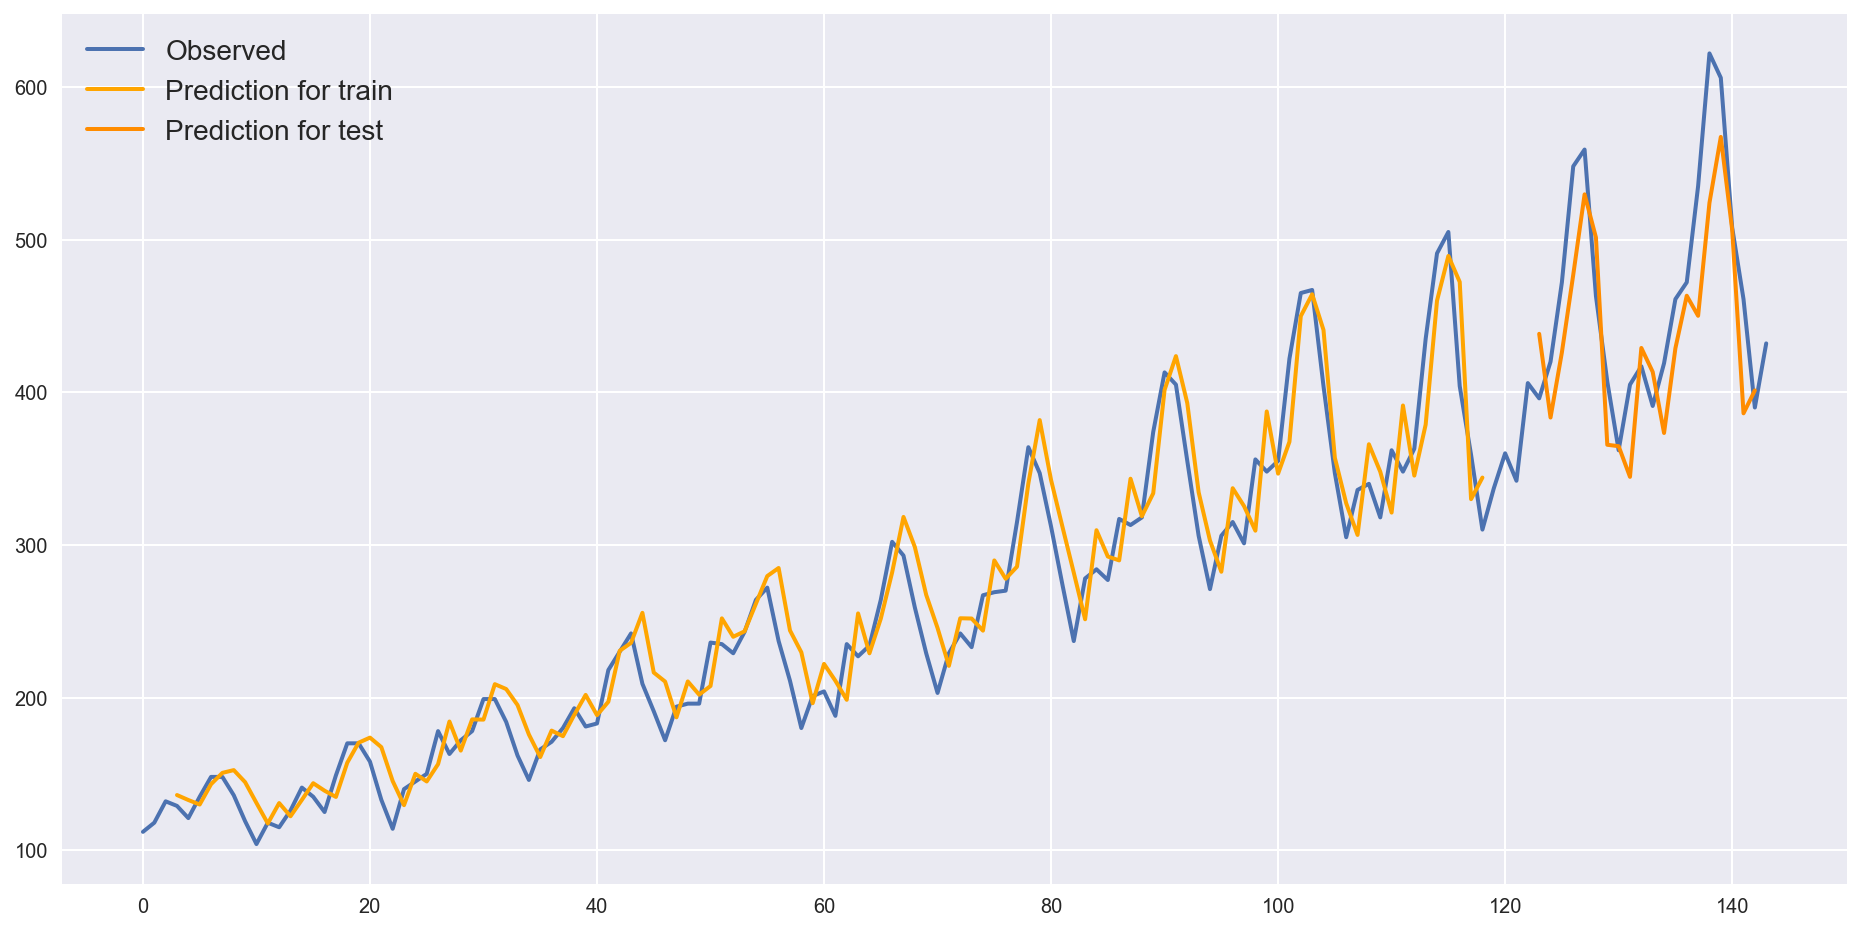

In [225]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags:len(train_predict)+lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (lags * 2)+1:len(data)-1, :] = test_predict

# plot observation and predictions
plt.plot(data, label='Observed');
plt.plot(train_predict_plot, label='Prediction for train', color='orange');
plt.plot(test_predict_plot, label='Prediction for test', color='darkorange');
plt.legend(loc='best');
plt.show()

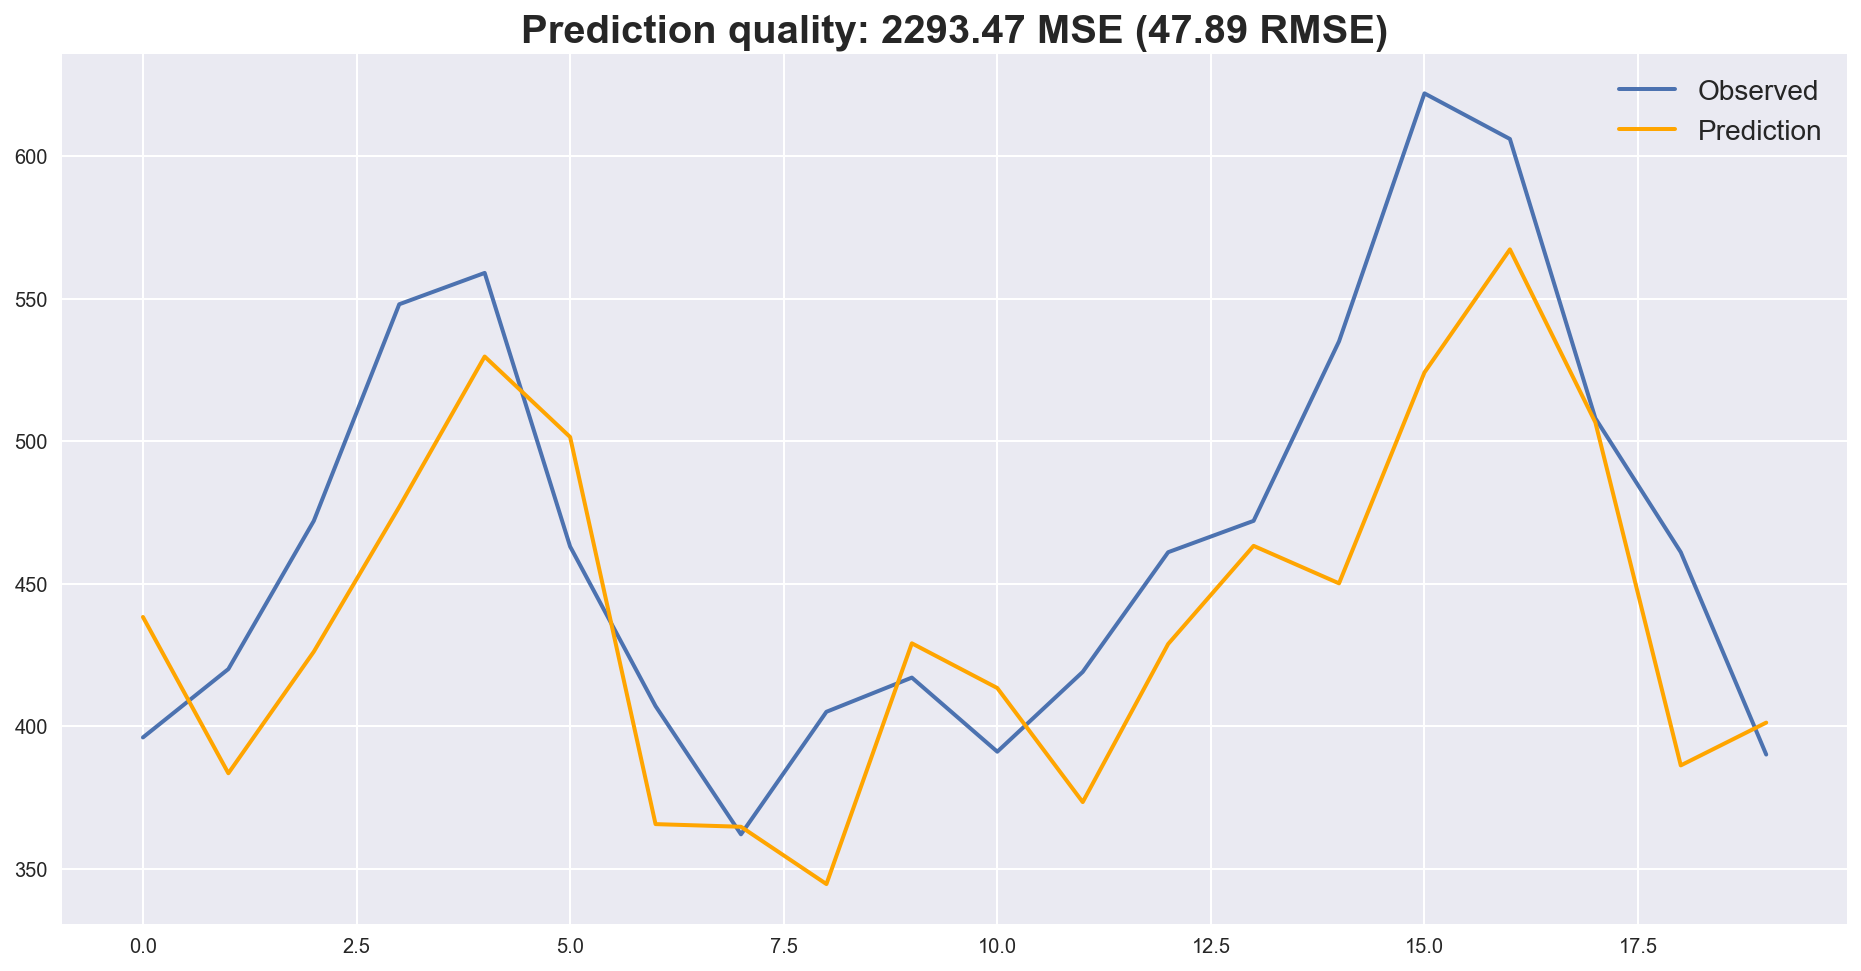

In [228]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='orange')
plt.legend(loc='best');
plt.show()

Prediction quality: 2293.47 MSE (47.89 RMSE)
